# **TOPIC MODELING MENGGUNAKAN BERTOPIC DENGAN LLAMA2 SEBAGAI TOPIC REPRESENTATION TUNING**

# Set Up

In [ ]:
!pip install hdbscan
!pip install bertopic
!pip install Sastrawi
!pip install -q -U bitsandbytes
!pip install transformers
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U einops
!pip install -q -U safetensors
!pip install -q -U torch
!pip install -q -U xformers
!pip install langchain pymysql --upgrade -q
!pip install sentence_transformers
!pip install langchain-experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039275 sha256=7ec19669e5625f06c2f8f923cec2781c4697933f6012b9d9cc48675df08ed9f7
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.9
    Uninstalling Cython-3.0.9:
      Successfully uninstalled Cython-3.0.9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━

In [ ]:
!pip install umap-learn

In [ ]:
import locale
# locale.getpreferredencoding = lambda: "UTF-8"
!pip install aspose-words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 MB 8.5 MB/s eta 0:00:00


In [ ]:
!pip install adjustText

# Dataset

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

data_tweet = pd.read_csv("/content/drive/MyDrive/Skripsi_Pemodelan_Topik-main/tweetsdetikcom.csv")
data_tweet.head(15)

,Tweet
0,"Gempa bumi dengan kekuatan magnitudo (M) 5,2 t..."
1,Pele adalah nama besar yang tak bisa ditolak-t...
2,Atletico Madrid melanjutkan kiprahnya di LaLig...
3,Istri Bripka HK berinisial IS protes dengan sa...
4,"Pelatih Timnas Thailand, Alexandre Polking men..."
5,"Cody Gakpo, yang sempat santer dikaitkan denga..."
6,BMKG mewanti-wanti adanya potensi hujan ekstre...
7,BMKG hari ini telah mengumumkan prakiraan cuac...
8,Pesepakbola legendaris Pele meninggal dunia. P...
9,Gemuruh Stadion Gelora Bung Karno bikin Manaje...


In [ ]:
data_tweet.shape

(10000, 1)

In [ ]:
data_tweet.head(1).values

array([['Gempa bumi dengan kekuatan magnitudo (M) 5,2 terjadi di Kabupaten Nias Selatan, Sumatera Utara. Gempa ada pada kedalaman 37 kilometer. https://t.co/xzS07zdvc3']],
      dtype=object)

In [ ]:
import re

In [ ]:
def preprocess_text(text):
        # mengubah tweet menjadi huruf kecil
        # text = text.lower()
        # menghilangkan url
        text = re.sub(r'https?:\/\/\S+','',text)
        # menghilangkan mention, link, hastag
        text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
        #menghilangkan karakter byte (b')
        text = re.sub(r'(b\'{1,2})',"", text)
        # menghilangkan yang bukan huruf
        # text = re.sub('[^a-zA-Z]', ' ', text)
        # menghilangkan digit angka
        # text = re.sub(r'\d+', '', text)
        #menghilangkan tanda baca
        # text = text.translate(str.maketrans("","",string.punctuation))
        # menghilangkan whitespace berlebih
        text = re.sub(r'\s+', ' ', text).strip()
        return text

In [ ]:
data_tweet['Tweet'] = data_tweet['Tweet'].apply(preprocess_text)

In [ ]:
data_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [ ]:
data_tweet.head(1).values

array([['Gempa bumi dengan kekuatan magnitudo (M) 5,2 terjadi di Kabupaten Nias Selatan, Sumatera Utara. Gempa ada pada kedalaman 37 kilometer.']],
      dtype=object)

In [ ]:
data_tweet.to_csv('detik_tweet_clean.csv', index=False)

# Building Model

In [ ]:
import transformers
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline, TextStreamer
from langchain.text_splitter import CharacterTextSplitter,  RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.document_loaders import DataFrameLoader
from langchain.chains import ConversationalRetrievalChain
from langchain.vectorstores import Chroma
from langchain.document_loaders.csv_loader import CSVLoader
# from langchain.vectorstores import FAISS
# from langchain.agents import create_pandas_dataframe_agent, create_csv_agent
from langchain.prompts import PromptTemplate
import pandas as pd
from langchain.indexes import VectorstoreIndexCreator

In [ ]:
import nltk
import re
import string
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic import BERTopic
import pandas as pd
import numpy as np
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemover, ArrayDictionary

## Llama **2**

In [ ]:
import os
cache_dir = "/content/drive/MyDrive/huggingface_cache_alvian"
os.makedirs(cache_dir, exist_ok=True) # Ensure the directory exists


### Load Quantized Model

In [ ]:
# model_id = "tribber93/Llama-2-7b-chat-hf-sharded-bf16-5GB" # sharded model by RonanKMcGovern. Change the model here to load something else.
# model_id = "tribber93/Mistral-7B-Instruct-v0.1-sharded-bf16-5GB"
model_id = "guardrail/llama-2-7b-guanaco-instruct-sharded"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

config = transformers.AutoConfig.from_pretrained(model_id, trust_remote_code=True)
config.init_device = 'cuda:0' # Unclear whether this really helps a lot or interacts with device_map.

tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir=cache_dir)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_id, config=config, quantization_config=bnb_config, device_map='auto', trust_remote_code=True, cache_dir=cache_dir) # for inference use 'auto', for training us device_map={"":0}

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model-00009-of-00014.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00010-of-00014.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00011-of-00014.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00012-of-00014.safetensors:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

model-00013-of-00014.safetensors:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

model-00014-of-00014.safetensors:   0%|          | 0.00/1.69G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)


### **Prompt Engineering**

To check whether our model is correctly loaded, let's try it out with a few prompts.

In [ ]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

In [ ]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

In [ ]:
# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more and use indonesian.
[/INST]
"""

In [ ]:
prompt = system_prompt + example_prompt + main_prompt

## 🗨️ **BERTopic**

Before we can start with topic modeling, we will first need to perform two steps:
* Pre-calculating Embeddings
* Defining Sub-models

## **Preparing Embeddings**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test = train_test_split(data_tweet, test_size=0.2, random_state=1)

In [ ]:
X_train.shape

(8000, 1)

In [ ]:
X_test.shape

(2000, 1)

In [ ]:
X_train.to_csv("/content/drive/MyDrive/Skripsi/detik_tweet_clean_train.csv", index=False)

In [ ]:
X_test.to_csv("/content/drive/MyDrive/Skripsi/detik_tweet_clean_test.csv", index=False)

In [ ]:
tweets = X_train['Tweet'].to_list()

In [ ]:
X_train

,Tweet
2694,Yakin kalau otakmu sudah cerdas? Hanya orang d...
5140,Lee Jenog Hoon ditipu penyedia jasa penyewaan ...
2568,"Ketua Umum PSSI, Mochamad Iriawan, membuat pen..."
3671,Pemerintah melaporkan kasus baru Corona (COVID...
7427,Terekam CCTV aksi penculikan seorang bocah ber...
...,...
2895,Manajer Erik ten Hag melakukan hal baru untuk ...
7813,Pria berinisial FF (20) membunuh DNY (20) kare...
905,Presenter Indra Bekti dilarikan ke rumah sakit...
5192,"Setiap tanggal 22 Desember, Indonesia memperin..."


In [ ]:
len(tweets)

8000

In [ ]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer('firqaaa/indo-sentence-bert-base')
embeddings = embedding_model.encode(tweets, show_progress_bar=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/709k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
embeddings

array([[ 0.12167774,  0.74904317, -0.48050922, ...,  0.32872972,
        -0.37100074, -0.6426135 ],
       [-0.79421717, -1.5505716 ,  0.69183743, ..., -0.6378607 ,
         0.39051893, -1.4625129 ],
       [ 0.07953576,  0.02178915,  0.2139527 , ...,  0.7292372 ,
        -0.19219945, -0.24443367],
       ...,
       [-0.8787739 ,  0.6899277 ,  1.6975595 , ..., -0.10750152,
        -0.22226469, -0.5265464 ],
       [-0.9267678 ,  1.534771  ,  1.5832443 , ..., -0.4211429 ,
         0.92325515,  0.7792728 ],
       [-0.24227808, -0.31294015,  0.586743  , ...,  1.1186346 ,
        -0.6761073 , -0.01482023]], dtype=float32)

## **Sub-models**

Next, we will define all sub-models in BERTopic and do some small tweaks to the number of clusters to be created, setting random states, etc.

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN

#Model yang asli
# umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# Untuk melihat perbandingan/model baseline
umap_model = UMAP(n_neighbors=15, n_components=5,  metric='cosine', random_state=42)

#Model yang asli
# hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# Untuk melihat perbandingan/model baseline
hdbscan_model = HDBSCAN(min_cluster_size=25, metric='euclidean', cluster_selection_method='eom', prediction_data=True)


As a small bonus, we are going to reduce the embeddings we created before to 2-dimensions so that we can use them for visualization purposes when we have created our topics.

In [ ]:
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

In [ ]:
reduced_embeddings

array([[10.179811 ,  2.3265872],
       [10.867761 ,  5.0364385],
       [14.072003 ,  7.0287814],
       ...,
       [11.972929 ,  3.1897755],
       [ 8.193378 ,  2.4369965],
       [ 9.124554 ,  2.5598738]], dtype=float32)

### **Representation Models**

One of the ways we are going to represent the topics is with Llama 2 which should give us a nice label. However, we might want to have additional representations to view a topic from multiple angles.

Here, we will be using c-TF-IDF as our main representation and [KeyBERT](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired), [MMR](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance), and [Llama 2](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html) as our additional representations.

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
# keybert = KeyBERTInspired()

# MMR
# mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
# representation_model = {
#     "KeyBERT": keybert,
#     "Llama2": llama2,
#     "MMR": mmr,
# }

representation_model = {
    # "KeyBERT": keybert,
    "Llama2": llama2,
    # "MMR": mmr,
}

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [ ]:
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
list_stopwords = stopwords.words('indonesian')

In [ ]:
vectorizer_model = CountVectorizer(stop_words=list_stopwords)

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  vectorizer_model=vectorizer_model,

  # Hyperparameters
  # top_n_words=10,
  verbose=True
)


# Train model
topics, probs = topic_model.fit_transform(tweets, embeddings)


2024-03-24 21:09:12,978 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-24 21:09:32,567 - BERTopic - Dimensionality - Completed ✓
2024-03-24 21:09:32,568 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-24 21:09:32,939 - BERTopic - Cluster - Completed ✓
2024-03-24 21:09:32,959 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 49/49 [05:35<00:00,  6.84s/it]
2024-03-24 21:15:08,888 - BERTopic - Representation - Completed ✓


Now that we are done training our model, let's see what topics were generated:

In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Llama2,Representative_Docs
0,-1,2527,-1_via_polisi_orang_viral,"[via, polisi, orang, viral, jakarta, korban, a...",[Polres Metro Jakarta Selatan dan Polri menyel...,[Sebuah video menunjukkan aliran pasir diduga ...
1,0,1381,0_piala_dunia_2022_argentina,"[piala, dunia, 2022, argentina, messi, prancis...","[Liga Dunia 2022: Argentina vs Prancis, , , , ...",[Warga Argentina menaruh harapan tinggi terhad...
2,1,671,1_natal_libur_gereja_tol,"[natal, libur, gereja, tol, 2023, nataru, wisa...",[Traffic jam during Christmas and New Year hol...,[Sebanyak 40 juta kendaraan diprediksi akan me...
3,2,209,2_pria_korban_via_pelaku,"[pria, korban, via, pelaku, wanita, _jatim, di...","[Murder cases in Indonesia, , , , , , , , , ]",[Pria inisial MU (26) di Nunukan yang membunuh...
4,3,206,3_sambo_yosua_ferdy_brigadir,"[sambo, yosua, ferdy, brigadir, ahli, pembunuh...","[Pembunuhan Brigadir Yosua Hutabarat, , , , , ...",[Ahli poligraf dihadirkan sebagai saksi di sid...
5,4,171,4_covid_19_china_pasien,"[covid, 19, china, pasien, vaksin, lonjakan, c...","[Covid-19 dan situasi di China, , , , , , , , , ]",[Jokowi memberi sinyal PPKM dihentikan tapi ts...
6,5,155,5_kpk_jatim_sahat_dprd,"[kpk, jatim, sahat, dprd, tua, wakil, menggele...",[KPK Operations Against Corruption in East Jav...,[KPK melakukan operasi tangkap tangan (OTT) te...
7,6,140,6_rusia_ukraina_zelensky_pesawat,"[rusia, ukraina, zelensky, pesawat, presiden, ...","[Invasi Rusia ke Ukraina, , , , , , , , , ]",[Presiden Rusia Vladimir Putin mengatakan bahw...
8,7,124,7_saw_islam_allah_rasulullah,"[saw, islam, allah, rasulullah, nabi, swt, sal...","[Label: Islam dan Kiamat, , , , , , , , , ]",[Al-Qur'an yang diturunkan Allah SWT kepada Na...
9,8,113,8_magang_lowongan_pppk_mahasiswa,"[magang, lowongan, pppk, mahasiswa, 2023, seko...","[Lowongan Magang 2023, , , , , , , , , ]",[BMKG membuka lowongan PPPK 2022 untuk 151 for...


In [ ]:
topics

[-1,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 4,
 0,
 -1,
 0,
 0,
 1,
 11,
 -1,
 36,
 1,
 15,
 19,
 -1,
 -1,
 7,
 6,
 1,
 8,
 -1,
 -1,
 7,
 0,
 9,
 -1,
 -1,
 6,
 42,
 33,
 -1,
 44,
 -1,
 27,
 0,
 -1,
 -1,
 -1,
 27,
 -1,
 0,
 18,
 2,
 -1,
 9,
 -1,
 21,
 22,
 4,
 2,
 45,
 1,
 0,
 -1,
 17,
 2,
 44,
 1,
 1,
 42,
 -1,
 8,
 -1,
 24,
 39,
 21,
 44,
 11,
 -1,
 21,
 -1,
 32,
 23,
 43,
 0,
 3,
 -1,
 -1,
 -1,
 1,
 26,
 18,
 19,
 1,
 -1,
 -1,
 45,
 10,
 18,
 12,
 31,
 3,
 22,
 10,
 45,
 -1,
 15,
 -1,
 11,
 0,
 16,
 22,
 -1,
 -1,
 0,
 31,
 42,
 0,
 0,
 0,
 -1,
 10,
 -1,
 0,
 11,
 -1,
 14,
 0,
 16,
 37,
 -1,
 0,
 1,
 -1,
 0,
 -1,
 17,
 -1,
 25,
 3,
 -1,
 0,
 6,
 6,
 1,
 -1,
 0,
 5,
 -1,
 -1,
 0,
 8,
 17,
 9,
 -1,
 -1,
 -1,
 3,
 -1,
 13,
 -1,
 5,
 3,
 11,
 7,
 5,
 0,
 -1,
 2,
 27,
 0,
 0,
 -1,
 7,
 -1,
 8,
 -1,
 5,
 46,
 -1,
 -1,
 16,
 8,
 1,
 0,
 -1,
 -1,
 -1,
 7,
 0,
 40,
 5,
 2,
 -1,
 42,
 0,
 26,
 1,
 15,
 24,
 29,
 -1,
 -1,
 -1,
 17,
 -1,
 4,
 5,
 10,
 12,
 -1,
 20,
 -1,
 0,
 0,
 0,
 1,
 0,
 -1,
 2,
 -1,
 2

In [ ]:
predicted_topics, _pre = topic_model.transform(tweets)

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

2024-03-24 21:21:24,358 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-03-24 21:21:24,456 - BERTopic - Dimensionality - Completed ✓
2024-03-24 21:21:24,465 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-03-24 21:21:25,634 - BERTopic - Cluster - Completed ✓


In [ ]:
pd.DataFrame(
    {
        "topics" : topics,
        "predicted_topics":predicted_topics
    }
)

,topics,predicted_topics
0,-1,-1
1,-1,-1
2,0,0
3,-1,-1
4,-1,-1
...,...,...
7995,0,0
7996,2,2
7997,43,43
7998,1,1


In [ ]:
topic_model.get_topic(8, full=True)["Llama2"]

TypeError: 'bool' object is not subscriptable

We got over 100 topics that were created and they all seem quite diverse.We can use the labels by Llama 2 and assign them to topics that we have created. Normally, the default topic representation would be c-TF-IDF, but we will focus on Llama 2 representations instead.


In [ ]:
llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]
topic_model.set_topic_labels(llama2_labels)

# Evaluasi Coherence Score CV

## Training

In [ ]:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel


In [ ]:
documents = pd.DataFrame({"Document": tweets,
                          "ID": range(len(tweets)),
                          "Topic": topics})

In [ ]:
documents

,Document,ID,Topic
0,Yakin kalau otakmu sudah cerdas? Hanya orang d...,0,-1
1,Lee Jenog Hoon ditipu penyedia jasa penyewaan ...,1,-1
2,"Ketua Umum PSSI, Mochamad Iriawan, membuat pen...",2,0
3,Pemerintah melaporkan kasus baru Corona (COVID...,3,-1
4,Terekam CCTV aksi penculikan seorang bocah ber...,4,-1
...,...,...,...
7995,Manajer Erik ten Hag melakukan hal baru untuk ...,7995,0
7996,Pria berinisial FF (20) membunuh DNY (20) kare...,7996,2
7997,Presenter Indra Bekti dilarikan ke rumah sakit...,7997,43
7998,"Setiap tanggal 22 Desember, Indonesia memperin...",7998,1


In [ ]:
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})

In [ ]:
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

In [ ]:
# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

In [ ]:
# Use .get_feature_names_out() if you get an error with .get_feature_names()
words = vectorizer.get_feature_names_out()

In [ ]:
# Extract features for Topic Coherence evaluation
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]

In [ ]:
for i in tokens :
  print(len(i))

36003
20435
9519
3196
3188
2365
2584
1972
1358
1395
1606
1519
1645
1349
1520
1254
1317
1163
956
931
1036
935
1055
1030
1007
729
887
858
911
804
805
652
711
694
639
551
474
563
440
527
464
523
397
428
426
467
522
459
355


In [ ]:
# Extract words in each topic if they are non-empty and exist in the dictionary
topic_words = []
for topic in range(-1, len(set(topics))-1):
    words = list(zip(*topic_model.get_topic(topic)))[0]
    words = [word for word in words if word in dictionary.token2id]
    topic_words.append(words)
topic_words = [words for words in topic_words if len(words) > 0]

In [ ]:
# Evaluate Coherence
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')
coherence = coherence_model.get_coherence()

In [ ]:
coherence

0.8573144263257145

In [ ]:
topic_coherence_cv = coherence_model.get_coherence_per_topic(segmented_topics=None, with_std=False, with_support=False)

In [ ]:
len(topic_coherence_cv)

49

In [ ]:
topic_words = [[words for words, _ in topic_model.get_topic(topic)]
               for topic in range(-1, len(set(topics))-1)]

In [ ]:
x = len(topic_words)
y = len(topic_words[0])
z = len(topic_words[0][0])

In [ ]:
daftar_topik = []
daftar_kata_arr = []
for i in range(x):
    daftar_kata = ""
    for j in range(y):
        o = topic_words[i][j]
        daftar_kata_arr.append(o)
    daftar_kata = ", ".join(daftar_kata_arr)
    daftar_topik.append(daftar_kata)
    daftar_kata_arr.clear()

In [ ]:
coherence_score_topics = pd.DataFrame(
      {
          "Topic":  range(-1, len(daftar_topik)-1),
          "Daftar_Kata": daftar_topik,
          "Cohrence Score CV": topic_coherence_cv,
      }
  )

In [ ]:
coherence_score_topics

,Topic,Daftar_Kata,Cohrence Score CV
0,-1,"via, polisi, orang, viral, jakarta, korban, an...",0.566223
1,0,"piala, dunia, 2022, argentina, messi, prancis,...",0.901432
2,1,"natal, libur, gereja, tol, 2023, nataru, wisat...",0.832657
3,2,"pria, korban, via, pelaku, wanita, _jatim, dit...",0.742517
4,3,"sambo, yosua, ferdy, brigadir, ahli, pembunuha...",0.974818
5,4,"covid, 19, china, pasien, vaksin, lonjakan, co...",0.922937
6,5,"kpk, jatim, sahat, dprd, tua, wakil, menggeled...",0.922053
7,6,"rusia, ukraina, zelensky, pesawat, presiden, v...",0.906903
8,7,"saw, islam, allah, rasulullah, nabi, swt, sala...",0.966450
9,8,"magang, lowongan, pppk, mahasiswa, 2023, sekol...",0.850145


In [ ]:
coherence_score_topics.to_excel('fix_coherence_score_training.xlsx')

In [ ]:
jumlah_tweet = topic_model.get_topic_info()['Count'].values

In [ ]:
topic_representation = []

for i in  range(-1, len(set(topics))-1):
  topic_i = topic_model.get_topic(i, full=True)['Llama2'][0][0]
  topic_representation.append(topic_i)

In [ ]:
jumlah_kata = [len(i) for i in tokens]

In [ ]:
len(jumlah_kata)

49

In [ ]:
topic_results_training = pd.DataFrame(
      {
          "Topic":  range(-1, len(daftar_topik)-1),
          "Jumlah Tweet": jumlah_tweet,
          "Jumlah Kata": jumlah_kata,
          "Representasi Topik": topic_representation,
      }
  )

In [ ]:
topic_results_training

,Topic,Jumlah Tweet,Jumlah Kata,Representasi Topik
0,-1,2527,36003,Polres Metro Jakarta Selatan dan Polri menyeli...
1,0,1381,20435,Liga Dunia 2022: Argentina vs Prancis
2,1,671,9519,Traffic jam during Christmas and New Year holi...
3,2,209,3196,Murder cases in Indonesia
4,3,206,3188,Pembunuhan Brigadir Yosua Hutabarat
5,4,171,2365,Covid-19 dan situasi di China
6,5,155,2584,KPK Operations Against Corruption in East Java...
7,6,140,1972,Invasi Rusia ke Ukraina
8,7,124,1358,Label: Islam dan Kiamat
9,8,113,1395,Lowongan Magang 2023


In [ ]:
topic_results_training.to_excel('fix_topic_results_training.xlsx')

# 📊 **Visualize**
We can go through each topic manually, which would take a lot of work, or we can visualize them all in a single interactive graph.
BERTopic has a bunch of [visualization functions](https://medium.com/r/?url=https%3A%2F%2Fmaartengr.github.io%2FBERTopic%2Fgetting_started%2Fvisualization%2Fvisualize_documents.html) that we can use. For now, we are sticking with visualizing the documents.

In [ ]:
topic_model.visualize_documents(tweets, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=False)

# 🖼️ **Advanced Visualization**

Although we can use the built-in visualization features of BERTopic, we can also create a static visualization that might be a bit more informative.

We start by creating the necessary variables that contain our reduced embeddings and representations:

In [ ]:
import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings[:, 0], "y": reduced_embeddings[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in tweets]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

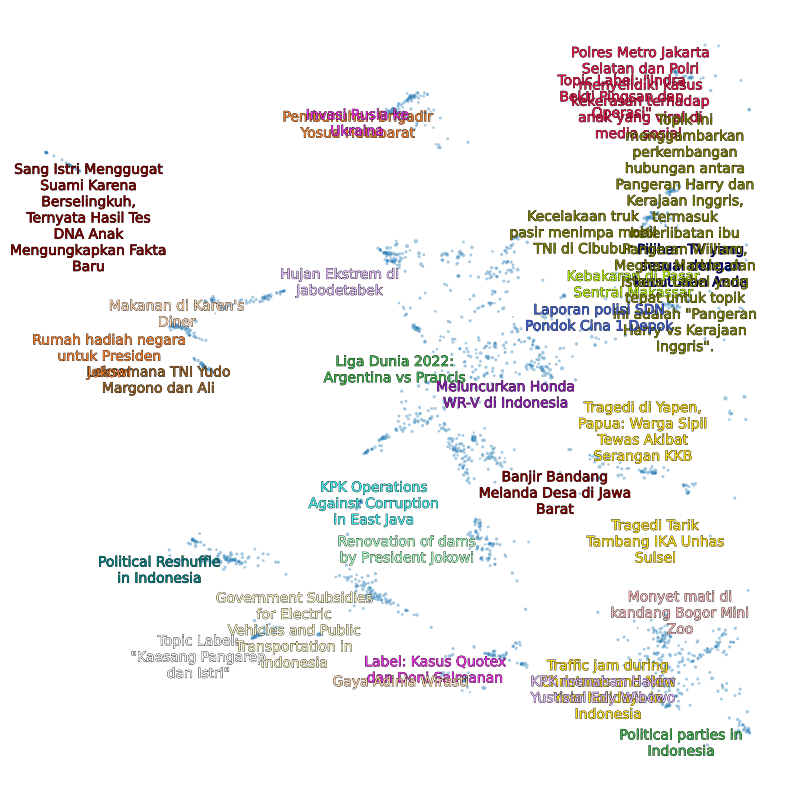

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe
import textwrap

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4, sizes=(0.4, 10), size="Length")

# Annotate top 50 topics
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = textwrap.fill(topic_model.custom_labels_[int(topic)], 20)

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]
                          ))

# Adjust annotations such that they do not overlap
adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.axis('off')
plt.legend('', frameon=False)
plt.show()

# Backup Saving

In [ ]:
# To save: model, reduced embeddings, representative docs
!pip install safetensors

In [ ]:
import pickle

with open('/content/drive/MyDrive/Skripsi/Bertopic_Llama2/rep_docs_3.pickle', 'wb') as handle:
    pickle.dump(topic_model.representative_docs_, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Skripsi/Bertopic_Llama2/reduced_embeddings_3.pickle', 'wb') as handle:
    pickle.dump(reduced_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
embedding_model = "'firqaaa/indo-sentence-bert-base'"
topic_model.save("/content/drive/MyDrive/Skripsi/Bertopic_Llama2/final_5_training", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [ ]:
BERTopic_model = BERTopic.load("/content/drive/MyDrive/Skripsi/Bertopic_Llama2/final_5_training")

2024-02-29 15:35:13,274 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model.If you want to also load in an embedding model, make sure to useBERTopic.load(my_model, embedding_model=my_embedding_model).


In [ ]:
BERTopic_model.visualize_barchart()

In [ ]:
BERTopic_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,Llama2,Representative_Docs
0,-1,2527,-1_via_polisi_orang_viral,Polres Metro Jakarta Selatan dan Polri menyeli...,"[via, polisi, orang, viral, jakarta, korban, a...",[Polres Metro Jakarta Selatan dan Polri menyel...,NaN
1,0,1381,0_piala_dunia_2022_argentina,Liga Dunia 2022: Argentina vs Prancis,"[piala, dunia, 2022, argentina, messi, prancis...","[Liga Dunia 2022: Argentina vs Prancis, , , , ...",NaN
2,1,671,1_natal_libur_gereja_tol,Traffic jam during Christmas and New Year holi...,"[natal, libur, gereja, tol, 2023, nataru, wisa...",[Traffic jam during Christmas and New Year hol...,NaN
3,2,209,2_pria_korban_via_pelaku,Murder cases in Indonesia,"[pria, korban, via, pelaku, wanita, _jatim, di...","[Murder cases in Indonesia, , , , , , , , , ]",NaN
4,3,206,3_sambo_yosua_ferdy_brigadir,Pembunuhan Brigadir Yosua Hutabarat,"[sambo, yosua, ferdy, brigadir, ahli, pembunuh...","[Pembunuhan Brigadir Yosua Hutabarat, , , , , ...",NaN
5,4,171,4_covid_19_china_pasien,Covid-19 dan situasi di China,"[covid, 19, china, pasien, vaksin, lonjakan, c...","[Covid-19 dan situasi di China, , , , , , , , , ]",NaN
6,5,155,5_kpk_jatim_sahat_dprd,KPK Operations Against Corruption in East Java,"[kpk, jatim, sahat, dprd, tua, wakil, menggele...",[KPK Operations Against Corruption in East Jav...,NaN
7,6,140,6_rusia_ukraina_zelensky_pesawat,Invasi Rusia ke Ukraina,"[rusia, ukraina, zelensky, pesawat, presiden, ...","[Invasi Rusia ke Ukraina, , , , , , , , , ]",NaN
8,7,124,7_saw_islam_allah_rasulullah,Label: Islam dan Kiamat,"[saw, islam, allah, rasulullah, nabi, swt, sal...","[Label: Islam dan Kiamat, , , , , , , , , ]",NaN
9,8,113,8_magang_lowongan_pppk_mahasiswa,Lowongan Magang 2023,"[magang, lowongan, pppk, mahasiswa, 2023, seko...","[Lowongan Magang 2023, , , , , , , , , ]",NaN


In [ ]:
BERTopic_model.c_tf_idf_

<49x16121 sparse matrix of type '<class 'numpy.float64'>'
	with 35581 stored elements in Compressed Sparse Row format>

In [ ]:
feature_names_out = BERTopic_model.vectorizer_model.get_feature_names_out()
feature_names_out

array(['00', '000', '004', ..., 'zulpan', 'zx', 'ën'], dtype=object)

# Coherence Score

In [ ]:
import locale
import warnings
import os
import torch

# Ignore all warnings
warnings.filterwarnings('ignore')

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding

In [ ]:
from bertopic import BERTopic
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

topic_model = BERTopic(verbose=True, n_gram_range=(1, 3))
topics, _ = topic_model.fit_transform(tweets)

# Preprocess Documents
documents = pd.DataFrame({"Document": tweets,
                          "ID": range(len(tweets)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)]
               for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')
coherence = coherence_model.get_coherence()

2024-02-20 17:20:27,833 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2024-02-20 17:20:48,076 - BERTopic - Embedding - Completed ✓
2024-02-20 17:20:48,083 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-20 17:21:26,323 - BERTopic - Dimensionality - Completed ✓
2024-02-20 17:21:26,324 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-20 17:21:26,835 - BERTopic - Cluster - Completed ✓
2024-02-20 17:21:26,845 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-20 17:21:29,283 - BERTopic - Representation - Completed ✓


AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

# Implement


In [ ]:
import nltk
import re
import string
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic import BERTopic
import pandas as pd
import numpy as np
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns

class Pemodelan_Topik:
    def __init__(self):
        self.data = None
        self.tweets = None
        self.BERTopic_model = None
        self.jml_topik = None
        self.average_coherence_score = None
        self.coherence_score_topics = None
        self.min_coherence_score = None
        self.min_coherence_topic_id = None
        self.min_coherence_daftar_kata = None
        self.max_coherence_score = None
        self.max_coherence_topic_id = None
        self.max_coherence_daftar_kata = None

    def load_data(self, uploaded_file):
        # Use pandas to read the uploaded file
        self.data = pd.read_csv(uploaded_file, engine='python')

    def preprocess_text(self, text):
        # mengubah tweet menjadi huruf kecil
        # text = text.lower()
        # menghilangkan url
        text = re.sub(r'https?:\/\/\S+','',text)
        # menghilangkan mention, link, hastag
        text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
        #menghilangkan karakter byte (b')
        text = re.sub(r'(b\'{1,2})',"", text)
        # menghilangkan yang bukan huruf
        # text = re.sub('[^a-zA-Z]', ' ', text)
        # # menghilangkan digit angka
        # text = re.sub(r'\d+', '', text)
        # #menghilangkan tanda baca
        # text = text.translate(str.maketrans("","",string.punctuation))
        # # menghilangkan whitespace berlebih
        # text = re.sub(r'\s+', ' ', text).strip()
        return text

    def preprocess_tweets(self):
        self.tweets = self.data['Tweet'].apply(self.preprocess_text).to_list()

    def load_pemodelan_topik(self):
        self.BERTopic_model = BERTopic.load("/content/drive/MyDrive/Skripsi/Bertopic_Llama2/final_4_training",  embedding_model='firqaaa/indo-sentence-bert-base')

    def transform_pemodelan_topik(self):
        # Fit the model
        topics, probs = self.BERTopic_model.transform(self.tweets)
        self.data['topic'] = pd.Series(topics)
        return topics

    def count_words(self, id_topic):
        list_sentence = self.data[self.data['topic'] == id_topic]['Tweet'].to_list()
        sentence = ''.join(list_sentence)
        words = sentence.split()
        num_words = len(words)
        return num_words

    def evaluate_pemodelan_topik(self):
        topics = self.transform_pemodelan_topik()
        self.tweets = self.BERTopic_model._preprocess_text(self.tweets)
        # Extract vectorizer and tokenizer from BERTopic
        vectorizer = self.BERTopic_model.vectorizer_model
        tokenizer = vectorizer.build_tokenizer()

        # Extract features for Topic Coherence evaluation
        words = vectorizer.get_feature_names_out()
        tokens = [tokenizer(doc) for doc in self.tweets]
        dictionary = corpora.Dictionary(tokens)
        corpus = [dictionary.doc2bow(token) for token in tokens]
        topic_words = [[words for words, _ in self.BERTopic_model.get_topic(topic)]
                    for topic in range(len(set(topics))-1)]

        # Evaluate
        coherence_model_cv = CoherenceModel(topics=topic_words,
                                texts=tokens,
                                corpus=corpus,
                                dictionary=dictionary,
                                coherence='c_v')

        self.average_coherence_score = coherence_model_cv.get_coherence()

        topic_coherence_cv = coherence_model_cv.get_coherence_per_topic(segmented_topics=None, with_std=False, with_support=False)

        x = len(topic_words)
        y = len(topic_words[0])
        z = len(topic_words[0][0])

        daftar_topik = []
        daftar_kata_arr = []
        for i in range(x):
            daftar_kata = ""
            for j in range(y):
                o = topic_words[i][j]
                daftar_kata_arr.append(o)
            daftar_kata = ", ".join(daftar_kata_arr)
            daftar_topik.append(daftar_kata)
            daftar_kata_arr.clear()

        topic_id = []
        topic_coherence = []
        # topic_words = []

        i = 0
        for topics_coherence in topic_coherence_cv:
            topic_id.append(i)
            topic_coherence.append(topics_coherence)
            i += 1

        self.coherence_score_topics = pd.DataFrame(
                    {
                        "Topic": topic_id,
                        "Daftar_Kata": daftar_topik,
                        "Cohrence Score CV": topic_coherence,
                    }
                )

        num_words = []
        for i in self.coherence_score_topics['Topic']:
          num_words.append(self.count_words(i))

        self.coherence_score_topics['Jumlah Kata'] = pd.Series(num_words)
        id_min = topic_coherence.index(min(topic_coherence))
        id_max = topic_coherence.index(max(topic_coherence))
        self.jml_topik = len(topic_id)+1

        self.min_coherence_topic_id = topic_id[id_min]
        self.min_coherence_score = topic_coherence[id_min]
        self.min_coherence_daftar_kata = daftar_topik[id_min]
        self.max_coherence_topic_id = topic_id[id_max]
        self.max_coherence_score = topic_coherence[id_max]
        self.max_coherence_daftar_kata = daftar_topik[id_max]


In [ ]:
BERTopic_model = BERTopic.load("/content/drive/MyDrive/Skripsi/Bertopic_Llama2/final_4_training",  embedding_model='firqaaa/indo-sentence-bert-base')

2024-03-22 00:04:38,174 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model.If you want to also load in an embedding model, make sure to useBERTopic.load(my_model, embedding_model=my_embedding_model).


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/709k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
topics, probs = BERTopic_model.transform(tweets)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2024-03-22 00:07:24,035 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [ ]:
topics

array([39, 10, 38, ...,  0,  1,  1])

In [ ]:
len(topics)

2000

In [ ]:
len(X_test)

2000

In [ ]:
X_test.reset_index(drop='Index', inplace=True)

In [ ]:
X_test['topic'] = pd.Series(topics)

In [ ]:
pd.Series(topics).values

array([39, 10, 38, ...,  0,  1,  1])

In [ ]:
X_test

,Tweet,topic,representasi topik
0,Jurnalis yang meninggal dunia saat meliput Pia...,39,NaN
1,"Kepala BMKG Dwikorita mengatakan, peningkatan ...",10,NaN
2,Pertunjukan Christmas Carol kembali digelar di...,38,NaN
3,Sebanyak 619 anak di Bantul mengidap TBC didug...,2,NaN
4,Tahukah kamu kalau di Indonesia pernah ada uan...,44,NaN
...,...,...,...
1995,"Menurut jadwal Piala AFF 2022, Timnas Indonesi...",0,NaN
1996,Viral wanita ditaburkan obat bubuk di matanya ...,18,0.0
1997,Lionel Messi punya peluang untuk lewati raihan...,0,NaN
1998,Penumpang masih memadati Stasiun Pasar Senen. ...,1,NaN


In [ ]:
X_test['topic'].unique()

array([39, 10, 38,  2, 44, -1, 15, 19,  5,  6,  0, 31,  8, 29, 21, 20, 13,
        1,  7, 43, 36, 35, 27, 34, 46, 12, 28,  4,  9, 26, 37,  3, 24, 18,
       33, 32, 14, 17, 16, 45, 25, 41, 23, 30, 47, 11, 22, 40, 42])

In [ ]:
X_test['topic'].nunique()

49

In [ ]:
list_sentence_1 = X_train[X_train['topic'] == -1]['Tweet'].to_list()

In [ ]:
def count_words(text):
  words = text.split()
  return len(words)

In [ ]:
sentence_1 = ''.join(list_sentence_1)

In [ ]:
count_words(sentence_1)

3982

In [ ]:
def count_words(id_topic):
  list_sentence = data_tweet[data_tweet['topic'] == id_topic]['Tweet'].to_list()
  sentence = ''.join(list_sentence)
  words = sentence.split()
  num_words = len(words)
  return num_words



In [ ]:
count_words(0)

KeyError: 'topic'

In [ ]:
Pemodelan_Topik = Pemodelan_Topik()
# data_tweet = pd.read_csv("/content/drive/MyDrive/Skripsi_Pemodelan_Topik-main/tweetsdetikcom.csv", engine='python')
Pemodelan_Topik.load_data("/content/drive/MyDrive/Skripsi/detik_tweet_clean_train.csv")

In [ ]:
pd.read_csv("/content/drive/MyDrive/Skripsi/detik_tweet_clean_train.csv", engine='python')

,Tweet
0,Yakin kalau otakmu sudah cerdas? Hanya orang d...
1,Lee Jenog Hoon ditipu penyedia jasa penyewaan ...
2,"Ketua Umum PSSI, Mochamad Iriawan, membuat pen..."
3,Pemerintah melaporkan kasus baru Corona (COVID...
4,Terekam CCTV aksi penculikan seorang bocah ber...
...,...
7994,Manajer Erik ten Hag melakukan hal baru untuk ...
7995,Pria berinisial FF (20) membunuh DNY (20) kare...
7996,Presenter Indra Bekti dilarikan ke rumah sakit...
7997,"Setiap tanggal 22 Desember, Indonesia memperin..."


In [ ]:
Pemodelan_Topik.preprocess_tweets()

In [ ]:
Pemodelan_Topik.load_pemodelan_topik()
Pemodelan_Topik.transform_pemodelan_topik()
Pemodelan_Topik.evaluate_pemodelan_topik()

2024-02-29 15:41:46,843 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model.If you want to also load in an embedding model, make sure to useBERTopic.load(my_model, embedding_model=my_embedding_model).


Batches:   0%|          | 0/250 [00:00<?, ?it/s]

2024-02-29 15:42:04,956 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/250 [00:00<?, ?it/s]

2024-02-29 15:42:21,799 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [ ]:
df_topic_info = Pemodelan_Topik.BERTopic_model.get_topic_info()
df_topic_info

,Topic,Count,Name,CustomName,Representation,Llama2,Representative_Docs
0,-1,2527,-1_via_polisi_orang_viral,Polres Metro Jakarta Selatan dan Polri menyeli...,"[via, polisi, orang, viral, jakarta, korban, a...",[Polres Metro Jakarta Selatan dan Polri menyel...,NaN
1,0,1381,0_piala_dunia_2022_argentina,Liga Dunia 2022: Argentina vs Prancis,"[piala, dunia, 2022, argentina, messi, prancis...","[Liga Dunia 2022: Argentina vs Prancis, , , , ...",NaN
2,1,671,1_natal_libur_gereja_tol,Traffic jam during Christmas and New Year holi...,"[natal, libur, gereja, tol, 2023, nataru, wisa...",[Traffic jam during Christmas and New Year hol...,NaN
3,2,209,2_pria_korban_via_pelaku,Murder cases in Indonesia,"[pria, korban, via, pelaku, wanita, _jatim, di...","[Murder cases in Indonesia, , , , , , , , , ]",NaN
4,3,206,3_sambo_yosua_ferdy_brigadir,Pembunuhan Brigadir Yosua Hutabarat,"[sambo, yosua, ferdy, brigadir, ahli, pembunuh...","[Pembunuhan Brigadir Yosua Hutabarat, , , , , ...",NaN
5,4,171,4_covid_19_china_pasien,Covid-19 dan situasi di China,"[covid, 19, china, pasien, vaksin, lonjakan, c...","[Covid-19 dan situasi di China, , , , , , , , , ]",NaN
6,5,155,5_kpk_jatim_sahat_dprd,KPK Operations Against Corruption in East Java,"[kpk, jatim, sahat, dprd, tua, wakil, menggele...",[KPK Operations Against Corruption in East Jav...,NaN
7,6,140,6_rusia_ukraina_zelensky_pesawat,Invasi Rusia ke Ukraina,"[rusia, ukraina, zelensky, pesawat, presiden, ...","[Invasi Rusia ke Ukraina, , , , , , , , , ]",NaN
8,7,124,7_saw_islam_allah_rasulullah,Label: Islam dan Kiamat,"[saw, islam, allah, rasulullah, nabi, swt, sal...","[Label: Islam dan Kiamat, , , , , , , , , ]",NaN
9,8,113,8_magang_lowongan_pppk_mahasiswa,Lowongan Magang 2023,"[magang, lowongan, pppk, mahasiswa, 2023, seko...","[Lowongan Magang 2023, , , , , , , , , ]",NaN


In [ ]:
df_topic_info['Representation'][0]

['via',
 'polisi',
 'orang',
 'viral',
 'jakarta',
 'korban',
 'anak',
 '_jatim',
 'warga',
 'rumah']

In [ ]:
'Jumlah Topik '+str(Pemodelan_Topik.jml_topik)

'Jumlah Topik 49'

# Coherence Score Setiap Topik

In [ ]:
Pemodelan_Topik.coherence_score_topics

,Topic,Daftar_Kata,Cohrence Score CV,Jumlah Kata
0,0,"piala, dunia, 2022, argentina, messi, prancis,...",0.377716,24483
1,1,"natal, libur, gereja, tol, 2023, nataru, wisat...",0.336987,10248
2,2,"pria, korban, via, pelaku, wanita, _jatim, dit...",0.761159,6518
3,3,"sambo, yosua, ferdy, brigadir, ahli, pembunuha...",0.770329,4487
4,4,"covid, 19, china, pasien, vaksin, lonjakan, co...",0.364160,3753
5,5,"kpk, jatim, sahat, dprd, tua, wakil, menggeled...",0.305404,4580
6,6,"rusia, ukraina, zelensky, pesawat, presiden, v...",0.218298,2823
7,7,"saw, islam, allah, rasulullah, nabi, swt, sala...",0.288288,2881
8,8,"magang, lowongan, pppk, mahasiswa, 2023, sekol...",0.442996,2275
9,9,"anies, capres, baswedan, pdip, ganjar, 2024, p...",0.581888,4211


In [ ]:
Pemodelan_Topik.coherence_score_topics['Jumlah Kata'].unique()

array([24483, 10248,  6518,  4487,  3753,  4580,  2823,  2881,  2275,
        4211,  3135,  3203,  2468,  3730,  2790,  3752,  2953,  2311,
        3780,  1705,  3030,  1736,  3613,  1442,  2839,  1815,  2354,
        1546,  1466,  1635,  1588,  2809,  3996,  1350,  2228,  1010,
        1603,  3927,  2127,  2715,  1899,   976,  1587,  1529,  1024,
        1382,  2146])

In [ ]:
'Rata-rata Coherence Score '+str(Pemodelan_Topik.average_coherence_score)

'Rata-rata Coherence Score 0.5066505848165384'

In [ ]:
'Coherence Score Tertinggi '+str(Pemodelan_Topik.max_coherence_score)

'Coherence Score Tertinggi 0.9703686920365361'

In [ ]:
'Topik '+str(Pemodelan_Topik.max_coherence_topic_id)

'Topik 45'

In [ ]:
'Daftar Kata : '+str(Pemodelan_Topik.max_coherence_daftar_kata)

'Daftar Kata : tambang, tarik, unhas, ika, masyita, sulsel, tali, peserta, 43, panitia'

In [ ]:
'Coherence Score Terendah '+str(Pemodelan_Topik.min_coherence_score)

'Coherence Score Terendah 0.044630857411232815'

In [ ]:
'Topik '+str(Pemodelan_Topik.min_coherence_topic_id)

'Topik 37'

In [ ]:
'Daftar Kata : '+str(Pemodelan_Topik.min_coherence_daftar_kata)

'Daftar Kata : pangeran, meghan, harry, markle, charles, william, nathalie, kerajaan, merayakan, holscher'

# Topic Similarity Matrix

In [ ]:
Pemodelan_Topik.BERTopic_model.visualize_heatmap()